# **IMPORTS**



In [ ]:
import pandas as pd
import numpy as np
import sklearn.utils as skl
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from itertools import product
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA

# **CREATE DATAFRAME**

In [ ]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print(df.head())

Saving alzheimers_disease_data.csv to alzheimers_disease_data.csv
   PatientID  Age  Gender  Ethnicity  EducationLevel        BMI  Smoking  \
0       4751   73       0          0               2  22.927749        0   
1       4752   89       0          0               0  26.827681        0   
2       4753   73       0          3               1  17.795882        0   
3       4754   74       1          0               1  33.800817        1   
4       4755   89       0          0               0  20.716974        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  ...  MemoryComplaints  \
0           13.297218          6.327112     1.347214  ...                 0   
1            4.542524          7.619885     0.518767  ...                 0   
2           19.555085          7.844988     1.826335  ...                 0   
3           12.209266          8.428001     7.435604  ...                 0   
4           18.454356          6.310461     0.795498  ...                 0   

  

# **GENERATE DATA FOR TEST AND TRAINING**

            BMI  SleepQuality  FamilyHistoryAlzheimers  CardiovascularDisease  \
0     22.927749      9.025679                        0                      0   
1     26.827681      7.151293                        0                      0   
2     17.795882      9.673574                        1                      0   
3     33.800817      8.392554                        0                      0   
4     20.716974      5.597238                        0                      0   
...         ...           ...                      ...                    ...   
2144  39.121757      7.535540                        0                      0   
2145  17.857903      8.555256                        0                      0   
2146  15.476479      5.769464                        0                      0   
2147  15.299911      8.322874                        0                      1   
2148  33.289738      9.878711                        0                      0   

      Diabetes  Depression 

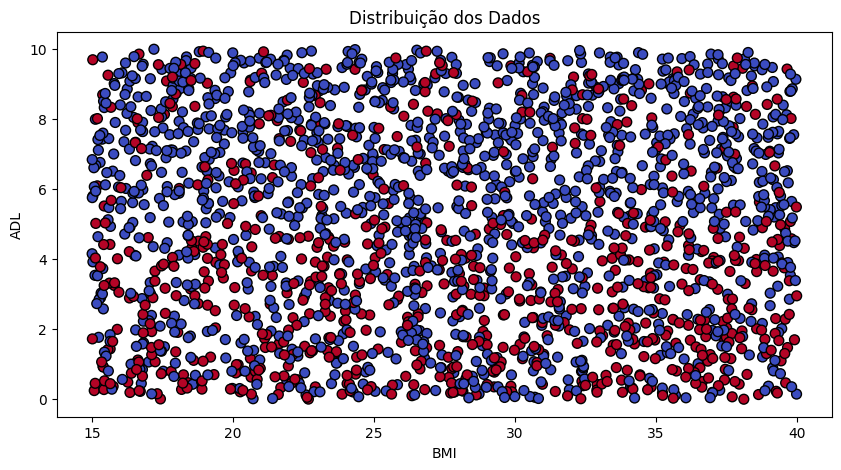

In [ ]:
X = df.drop(['Diagnosis', 'DoctorInCharge', 'PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'Smoking',
             'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks'], axis=1)
print(X)

y = df['Diagnosis']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

plt.figure(figsize=(10, 5))
plt.scatter(df['BMI'], df['ADL'], c=df['Diagnosis'], cmap='coolwarm', edgecolor='k', s=50)
plt.xlabel('BMI')
plt.ylabel('ADL')
plt.title('Distribuição dos Dados')
plt.show()

# **ACTIVATE FUNCTIONS**

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

# **MLP CLASS**

In [ ]:
class MLP_GRIDSEARCH:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate):
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []

        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.1)
            self.biases.append(np.zeros((1, layer_sizes[i+1])))

    def forward(self, X):
        self.a = [X]
        for i in range(len(self.weights) - 1):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            self.a.append(sigmoid(z))
        z = np.dot(self.a[-1], self.weights[-1]) + self.biases[-1]
        self.a.append(z)
        return self.a[-1]

    def backward(self, y_true):
        deltas = [self.a[-1] - y_true.reshape(-1, 1)]
        for i in reversed(range(len(self.weights) - 1)):
            deltas.append(deltas[-1].dot(self.weights[i + 1].T) * sigmoid_derivative(self.a[i + 1]))
        deltas.reverse()

        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.a[i].T.dot(deltas[i])
            self.biases[i] -= self.learning_rate * np.mean(deltas[i], axis=0, keepdims=True)

    def train(self, X, y, epochs=1000):
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = np.mean((y_pred - y.reshape(-1, 1))**2)
            self.backward(y)

    def predict(self, X):
        y_pred = self.forward(X)
        return np.round(y_pred).flatten().astype(int)

# **EVALUATE**

In [ ]:
def evaluate_grid_search(model, X, y):
    y_pred = model.predict(X)
    accuracy = np.mean(y_pred == y)
    return accuracy

# **CONFIG GRID_SEARCH**

In [ ]:
layers_and_neurons = [[5], [10], [20], [5, 5],[20,20], [10, 10]]
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
epochs = 1000
best_accuracy = -1
best_params = {}

# **GRID_SEARCH EXECUTE**

In [ ]:
input_size = X_train.shape[1]
y_train = y_train.values
y_test = y_test.values

for layers, learn_rate in product(layers_and_neurons, learning_rates):
    print(f"Treinando MLP com camadas ocultas: {layers}, taxa de aprendizado: {learn_rate}")
    mlp = MLP_GRIDSEARCH(input_size=input_size, hidden_sizes=layers, output_size=1, learning_rate=learn_rate)
    mlp.train(X_train, y_train, epochs=epochs)
    accuracy = evaluate_grid_search(mlp, X_test, y_test)
    print(f"Acurácia: {accuracy*100:.2f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'camadas e neuronios': layers, 'taxa de aprendizado': learn_rate}

print("Melhores parâmetros encontrados:", best_params)

Treinando MLP com camadas ocultas: [5], taxa de aprendizado: 0.1


<ipython-input-4-4f409a3d6097>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-5-a23b95478c3d>:34: RuntimeWarning: overflow encountered in square
  loss = np.mean((y_pred - y.reshape(-1, 1))**2)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
<ipython-input-5-a23b95478c3d>:24: RuntimeWarning: invalid value encountered in multiply
  deltas.append(deltas[-1].dot(self.weights[i + 1].T) * sigmoid_derivative(self.a[i + 1]))
<ipython-input-5-a23b95478c3d>:39: RuntimeWarning: invalid value encountered in cast
  return np.round(y_pred).flatten().astype(int)


Acurácia: 0.00
Treinando MLP com camadas ocultas: [5], taxa de aprendizado: 0.01
Acurácia: 0.00
Treinando MLP com camadas ocultas: [5], taxa de aprendizado: 0.001
Acurácia: 82.33
Treinando MLP com camadas ocultas: [5], taxa de aprendizado: 0.0001
Acurácia: 81.86
Treinando MLP com camadas ocultas: [5], taxa de aprendizado: 1e-05
Acurácia: 62.17
Treinando MLP com camadas ocultas: [10], taxa de aprendizado: 0.1
Acurácia: 0.00
Treinando MLP com camadas ocultas: [10], taxa de aprendizado: 0.01
Acurácia: 0.00
Treinando MLP com camadas ocultas: [10], taxa de aprendizado: 0.001
Acurácia: 0.00
Treinando MLP com camadas ocultas: [10], taxa de aprendizado: 0.0001
Acurácia: 81.55
Treinando MLP com camadas ocultas: [10], taxa de aprendizado: 1e-05
Acurácia: 69.15
Treinando MLP com camadas ocultas: [20], taxa de aprendizado: 0.1
Acurácia: 0.00
Treinando MLP com camadas ocultas: [20], taxa de aprendizado: 0.01
Acurácia: 0.00
Treinando MLP com camadas ocultas: [20], taxa de aprendizado: 0.001
Acurácia

# **CREATE MODEL BY GREAD_SEARCH_RESULT - MLP**





In [ ]:
def create_model():
    model = Sequential()
    model.add(Dense(5, input_dim=X_train.shape[1], activation='relu')) #Quantidade de camadas ocultas encontradas.
    for _ in range(4):
        model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.001) #Learning-Rate Encontrado
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
best_model = LogisticRegression(C=1.0, penalty='l2', solver='liblinear')

results = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'auc': []}
n_rounds = 10

for i in range(n_rounds):
    print(f"Executando rodada {i+1}/{n_rounds}...")

    model = create_model()
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    y_pred_proba = model.predict(X_test).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1_score'].append(f1)
    results['auc'].append(auc)

    print(f"Acurácia: {accuracy * 100:.2f}%")
    print(f"Precisão: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-Score: {f1 * 100:.2f}%")
    print(f"AUC: {auc * 100:.2f}%")
    print("\n")

print("\nResultados Finais:")
for metric in results:
    mean_value = np.mean(results[metric])
    std_value = np.std(results[metric])
    print(f"{metric.capitalize()}: Média = {mean_value * 100:.2f}%, Desvio Padrão = {std_value * 100:.2f}%")

Executando rodada 1/10...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Acurácia: 80.47%
Precisão: 76.11%
Recall: 70.49%
F1-Score: 73.19%
AUC: 86.51%


Executando rodada 2/10...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Acurácia: 80.62%
Precisão: 78.47%
Recall: 67.21%
F1-Score: 72.41%
AUC: 87.29%


Executando rodada 3/10...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Acurácia: 81.09%
Precisão: 76.52%
Recall: 72.13%
F1-Score: 74.26%
AUC: 85.89%


Executando rodada 4/10...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Acurácia: 81.24%
Precisão: 78.60%
Recall: 69.26%
F1-Score: 73.64%
AUC: 88.51%


Executando rodada 5/10...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Acurácia: 80.16%
Precisão: 78.16%
Recall: 65.98%
F1-Score: 71.56%
AUC: 86.10%


Executando rodada 6/10...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Acurácia: 80.47%
Precisão: 77.06%
Recall: 68.85%
F1-Score: 72.73%
AUC: 86.91%


Executando rodada 7/10...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Acurácia: 82.48%
Precisão: 80.18%
Recall: 71.31%
F1-Score: 75.49%
AUC: 88.77%


Executando rodada 8/10...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Acurácia: 81.71%
Precisão: 79.44%
Recall: 69.67%
F1-Score: 74.24%
AUC: 87.68%


Executando rodada 9/10...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Acurácia: 81.71%
Precisão: 78.90%
Recall: 70.49%
F1-Score: 74.46%
AUC: 88.75%


Executando rodada 10/10...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Acurácia: 83.88%
Precisão: 83.98%
Recall: 70.90%
F1-Score: 76.89%
AUC: 89.74%



Resultados Finais:
Accuracy: Média = 81.38%, Desvio Padrão = 1.07%
Precision: Média = 78.74%, Desvio Padrão = 2.13%
Recall: Média = 69.63%, Desvio Padrão = 1.79%
F1_score: Média = 73.89%, Desvio Padrão = 1.47%
Auc: Média = 87.62%, Desvio Padrão = 1.23%
